# Important Libraries

In [44]:
import math
from graphviz import Digraph

# Methods

In [45]:
def trace(root):
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges
def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    dot.node(name=uid, label="{%s | data %.4f | grad %.4f}" % (n.label, n.data, n.grad), shape="record")
    if n._operation:
      dot.node(name = uid + n._operation, label = n._operation)
      dot.edge(uid + n._operation, uid)
  for n1, n2 in edges:
    dot.edge(str(id(n1)), str(id(n2)) + n2._operation)

  return dot

# Value Class

In [46]:
class Value:

    def __init__(self, data, label = "", _operation = "", _children = ()):
        self.data = data
        self.label = label
        self._operation = _operation
        self._prev = set(_children)
        self.grad = 0.0
        self._backward = lambda : None
        

    def __repr__(self):
        _type = f"{type(self.data)}"
        result = f"Value(data = {self.data}, type = {_type})"
        return result

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        name_of_operation = " add "
        nodes = (self, other)
        operation = self.data + other.data
        result = Value(data = operation, _operation = name_of_operation, _children = nodes)
        def _backward():
            self.grad += 1.0 * result.grad
            other.grad += 1.0 * result.grad
        result._backward = _backward
        return result

    def __radd__(self, other):
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        name_of_operation = " mul "
        nodes = (self, other)
        operation = self.data * other.data
        result = Value(data = operation, _operation = name_of_operation, _children = nodes)
        def _backward():
            self.grad += other.data * result.grad
            other.grad += self.data * result.grad
        result._backward = _backward        
        return result

    def __rmul__(self, other):
        return self + other

    def __neg__(self):
        name_of_operation = f"neg({self.data})"
        nodes = (self, )
        operation = -self.data
        result = Value(
            data = operation, 
            label = f"-{self.label}" if self.label else "", 
            _children = nodes, 
            _operation = name_of_operation)
        return result

    def __sub__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        result = self + (-other)
        return result

    def __rsub__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        return other + (-self)

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Power should be ineger or float"
        name_of_operation = " pow "
        nodes = (self, )
        operation = self.data ** other
        result = Value(
            data = operation, 
            label = f"x^{self.label}" if self.label else "", 
            _children = nodes, 
            _operation = name_of_operation)
        def _backward():
            self.grad += (other * self.data ** (other - 1)) * result.grad
        result._backward = _backward   
        return result

    def __truediv__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        result = self * (other ** -1.0)
        return result

    def __rtruediv__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        return other * (self ** -1.0)

    def exp(self):
        x = self.data
        name_of_operation = " exp "
        nodes = (self, )
        operation = math.exp(x)
        result = Value(data = operation, _operation = name_of_operation, _children = nodes)
        def _backward():
            self.grad += x * result.grad
        result._backward = _backward   
        return result

    def tanh(self):
        x = self.data
        name_of_operation = " tanh "
        nodes = (self, )
        operation = (math.exp(2.0 * x) - 1) / (math.exp(2.0 * x) + 1)
        result = Value(data = operation, _operation = name_of_operation, _children = nodes)
        def _backward():
            self.grad += (1 - operation ** 2) * result.grad
        result._backward = _backward           
        return result

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
            for child in v._prev:
                build_topo(child)
            topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
            node._backward()

In [51]:
#data
x1 = Value(2.0, label = "x1")
x2 = Value(0.0, label = "x2")

#weight
w1 = Value(-3.0, label = "w1")
w2 = Value(1.0, label = "w2")

#bias
bias = Value(6.8813735870195432, label = "bias")

#x1w1
x1w1 = x1 * w1; x1w1.label = "x1w1"

#x2w2
x2w2 = x2 * w2; x2w2.label = "x2w2"

#x1w1x2w2
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = "x1w1x2w2"

#total sum + bias
L = x1w1x2w2 + bias; L.label = "L"

#tanh(L)
O = L.tanh(); O.label = "O"

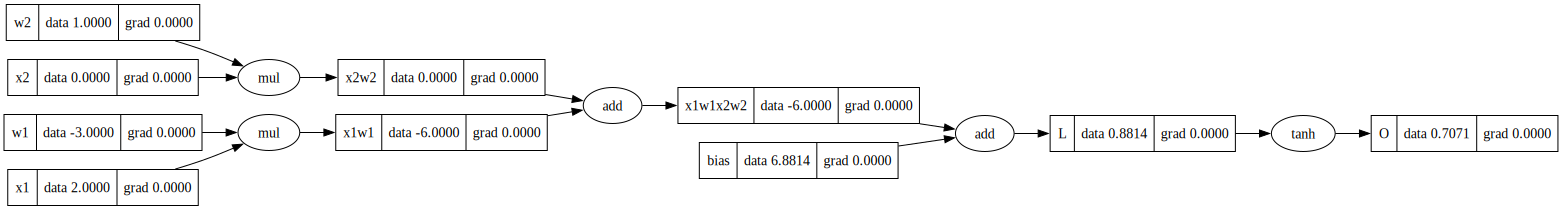

In [52]:
draw_dot(O)

In [53]:
O.backward()

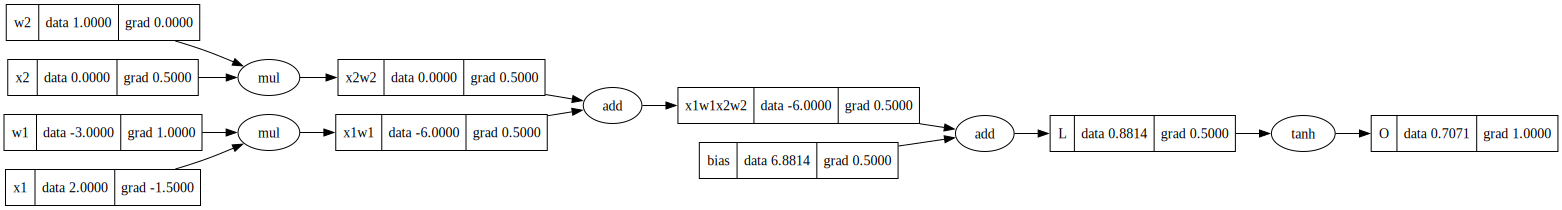

In [54]:
draw_dot(O)